# DL HW1

In [1]:
import numpy as np
import pandas as pd
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.image as mpimg
from collections import Counter
import torch
from torch.autograd import Variable
import torch.nn as nn
import cv2
from torchvision import transforms
from torch.optim import Adam
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder

# 1.DNN

## 1.1~1.2

In [2]:
data_train = np.load('problem1-DNN/train.npz', mmap_mode='r') 
data_train.files
data_test = np.load('problem1-DNN/test.npz', mmap_mode='r') 
data_test.files

['image', 'label']

In [3]:
train_X = data_train['image']
train_Y = data_train['label']
test_X = data_test['image']
test_Y = data_test['label']

In [4]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2])/np.max(train_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2])/np.max(test_X)
train_Y_one = pd.get_dummies(train_Y).values

In [13]:
np.random.seed(5)
class Deep_NN(object):
    
    def __init__(self):
        self.cross_entropy = []
        self.train_error_rate = []
        self.test_error_rate = []
        self.latent_features_X = []
        self.latent_features_Y = []
        self.W = None
        self.B = None
        
    def generate_WB(self, units, act):
        W = []
        B = []
        for i in range(len(units)-1):
            if act == 'zero':
                W.append(np.zeros((units[i], units[i+1])))
            elif act == 'random':
                W.append(np.random.normal(0, 1, (units[i], units[i+1]))*0.01)
            else:
                raise NotImplementedError('must be zero or random.')
            B.append(np.random.normal(0, 1, (units[i+1], 1))*0.01)
        return np.array(W), np.array(B)

    def activate(self, act, z):
        if act == 'relu':
            z[z <= 0] = 0
        elif act == 'softmax':
            z = np.exp(z)/sum(np.exp(z))
        else:
            raise NotImplementedError('must be relu or softmax.')
        return z

    def forward(self, X, W, B):
        Z = []
        A = [X]
        n_layer = len(W)
        for i in range(n_layer-1):
            Z.append(np.dot(W[i].T, A[i])+B[i])
            A.append(self.activate('relu', Z[i]))
        Z.append(np.dot(W[n_layer-1].T, A[n_layer-1])+B[n_layer-1])
        A.append(self.activate('softmax', Z[n_layer-1]))
        return np.array(Z), np.array(A) 

    def backward(self, t, Z, A, W):
        dW = []
        dB = []
        n_layer = len(W)
        for i in reversed(range(n_layer)):
            if i == n_layer-1:
                delta = A[i+1]-t
                dW.append(np.dot(A[i], delta.T))
                dB.append(delta)
            else:
                dz = np.ones((len(Z[i]), 1))
                dz[Z[i]<=0] = 0
                delta = np.dot(W[i+1], delta)*dz
                dW.append(np.dot(A[i], delta.T))
                dB.append(delta)

        return np.array(dW), np.array(dB)

    def nn_model(self, X, Y, test_X, test_Y, m, units, epoch, learn_rate):
        X_dim, X_n = X.shape
        Y_dim = Y.shape[1]
        testX_n = test_X.shape[1]
        self.W, self.B = self.generate_WB(units, 'random')
        for i in range(epoch):
            t1 = time.time()
            index = np.arange(X_n)
            np.random.shuffle(index)
            X = X[:,index]
            Y = Y[index]
            Ytrain_true = np.argmax(Y, axis=1)
            for j in range(int(X_n/m)):
                m_X = X[:, j*m:(j+1)*m]
                m_y = Y[j*m:(j+1)*m]
                dW_total = 0
                dB_total = 0
                for k in range(m):
                    x = m_X[:, k].reshape(X_dim, 1)
                    y = m_y[k].reshape(Y_dim, 1)
                    Z, A = self.forward(x, self.W, self.B)
                    dw, db = self.backward(y, Z, A, self.W)
                    dW_total = dW_total + dw
                    dB_total = dB_total + db
                self.W = self.W - learn_rate*dW_total[::-1]/m
                self.B = self.B - learn_rate*dB_total[::-1]/m
            _, train_A = self.forward(X, self.W, self.B)
            if i ==10 or i==50 or i==90 :
                self.latent_features_X.append(train_A[len(self.W)-1])
                self.latent_features_Y.append(Ytrain_true)
            Ytrain_pred = np.argmax(train_A[len(self.W)], axis=0)
            self.train_error_rate.append(1-sum(np.diag(confusion_matrix(Ytrain_true, Ytrain_pred)))/X_n)
            _, test_A = self.forward(test_X, self.W, self.B)
            Ytest_pred = np.argmax(test_A[len(self.W)], axis=0)
            self.test_error_rate.append(1-sum(np.diag(confusion_matrix(test_Y, Ytest_pred)))/testX_n)
            self.cross_entropy.append(-np.sum(np.log(train_A[len(self.W)])*Y.T)/X_n)
            t2 = time.time()
            print('epoch = %d, time = %f , loss = %f, train_error_rate = %f, test_error_rate = %f'\
                  % (i+1, t2-t1, self.cross_entropy[i], self.train_error_rate[i], self.test_error_rate[i]))

In [6]:
units = [train_X.T.shape[0], 15, 10, train_Y_one.shape[1]]
m = 120
epoch = 200
learn_rate = 0.1
DNN = Deep_NN()
DNN.nn_model(X=train_X.T, Y=train_Y_one, test_X=test_X.T, test_Y=test_Y, m=m, units=units, epoch=epoch, learn_rate=learn_rate)

epoch = 1, time = 0.885607 , loss = 2.291569, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 2, time = 0.998330 , loss = 2.289882, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 3, time = 0.960432 , loss = 2.289620, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 4, time = 0.913562 , loss = 2.289467, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 5, time = 0.914553 , loss = 2.288779, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 6, time = 0.900622 , loss = 2.275514, train_error_rate = 0.876167, test_error_rate = 0.884709
epoch = 7, time = 0.953458 , loss = 1.602539, train_error_rate = 0.629167, test_error_rate = 0.631241
epoch = 8, time = 0.850726 , loss = 1.326475, train_error_rate = 0.476083, test_error_rate = 0.484397
epoch = 9, time = 0.895606 , loss = 1.134060, train_error_rate = 0.438000, test_error_rate = 0.438107
epoch = 10, time = 0.873664 , loss = 0.684508, train_error_rate = 0.228833, test_e

epoch = 158, time = 0.893612 , loss = 0.003170, train_error_rate = 0.000083, test_error_rate = 0.068481
epoch = 159, time = 0.908570 , loss = 0.002744, train_error_rate = 0.000083, test_error_rate = 0.067614
epoch = 160, time = 1.125989 , loss = 0.002732, train_error_rate = 0.000083, test_error_rate = 0.067614
epoch = 161, time = 0.941483 , loss = 0.003248, train_error_rate = 0.000167, test_error_rate = 0.067788
epoch = 162, time = 0.900592 , loss = 0.002532, train_error_rate = 0.000083, test_error_rate = 0.067094
epoch = 163, time = 1.020272 , loss = 0.002956, train_error_rate = 0.000083, test_error_rate = 0.066921
epoch = 164, time = 0.924527 , loss = 0.002751, train_error_rate = 0.000167, test_error_rate = 0.068828
epoch = 165, time = 0.905579 , loss = 0.002560, train_error_rate = 0.000083, test_error_rate = 0.067961
epoch = 166, time = 1.123993 , loss = 0.002677, train_error_rate = 0.000083, test_error_rate = 0.066574
epoch = 167, time = 0.920538 , loss = 0.002649, train_error_rate

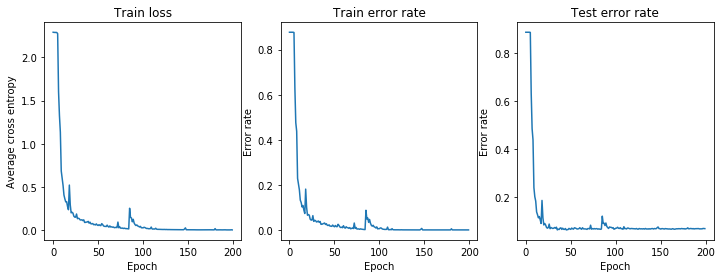

In [7]:
fig=plt.figure(figsize=(12,4))
##
plt.subplot(131) 
plt.plot(range(epoch), DNN.cross_entropy)
plt.xlabel("Epoch")
plt.ylabel("Average cross entropy")
plt.title('Train loss')
##
plt.subplot(132) 
plt.plot(range(epoch), DNN.train_error_rate)
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.title('Train error rate')
##
plt.subplot(133) 
plt.plot(range(epoch), DNN.test_error_rate)
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.title('Test error rate')

plt.show()

In [14]:
units = [train_X.T.shape[0], 15, 2, train_Y_one.shape[1]]
m = 120
epoch = 100
learn_rate = 0.1
DNN2 = Deep_NN()
DNN2.nn_model(X=train_X.T, Y=train_Y_one, test_X=test_X.T, test_Y=test_Y, m=m, units=units, epoch=epoch, learn_rate=learn_rate)

epoch = 1, time = 0.978384 , loss = 2.291587, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 2, time = 0.994341 , loss = 2.289993, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 3, time = 0.893612 , loss = 2.289667, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 4, time = 0.879648 , loss = 2.289474, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 5, time = 1.018277 , loss = 2.288789, train_error_rate = 0.877250, test_error_rate = 0.885402
epoch = 6, time = 0.902580 , loss = 2.278986, train_error_rate = 0.803083, test_error_rate = 0.809813
epoch = 7, time = 0.880645 , loss = 1.962846, train_error_rate = 0.763083, test_error_rate = 0.767164
epoch = 8, time = 0.949460 , loss = 1.579332, train_error_rate = 0.686667, test_error_rate = 0.692788
epoch = 9, time = 0.868677 , loss = 1.464709, train_error_rate = 0.647667, test_error_rate = 0.639563
epoch = 10, time = 0.849727 , loss = 1.435174, train_error_rate = 0.631500, test_e

## 1.3

Text(0.5, 1, 'Epoch=10')

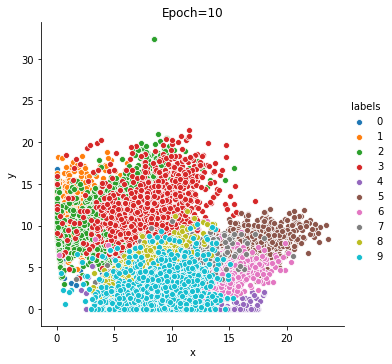

In [15]:
A10 = pd.DataFrame(DNN2.latent_features_X[0].T)
Y10 = pd.DataFrame(DNN2.latent_features_Y[0].T)
D10 = pd.concat([A10, Y10], axis=1)
D10.columns = ['x', 'y', 'labels']
sns.pairplot(x_vars=["x"], y_vars=["y"], data=D10, hue="labels", height=5)
plt.title('Epoch=10')

Text(0.5, 1, 'Epoch=50')

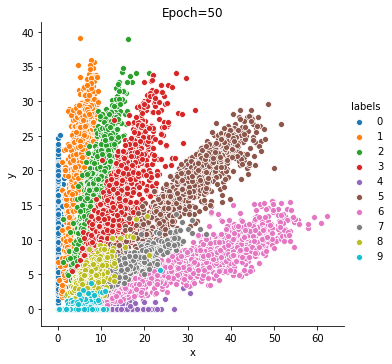

In [16]:
A50 = pd.DataFrame(DNN2.latent_features_X[1].T)
Y50 = pd.DataFrame(DNN2.latent_features_Y[1].T)
D50 = pd.concat([A50, Y50], axis=1)
D50.columns = ['x', 'y', 'labels']
sns.pairplot(x_vars=["x"], y_vars=["y"], data=D50, hue="labels", height=5)
plt.title('Epoch=50')

Text(0.5, 1, 'Epoch=90')

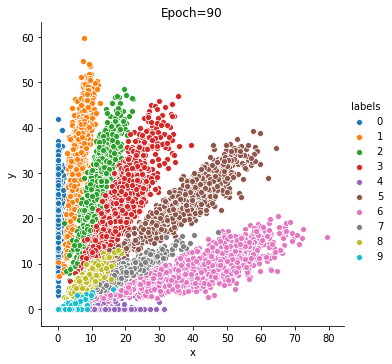

In [17]:
A90 = pd.DataFrame(DNN2.latent_features_X[2].T)
Y90 = pd.DataFrame(DNN2.latent_features_Y[2].T)
D90 = pd.concat([A90, Y90], axis=1)
D90.columns = ['x', 'y', 'labels']
sns.pairplot(x_vars=["x"], y_vars=["y"], data=D90, hue="labels", height=5)
plt.title('Epoch=90')

## 1.4

In [18]:
_, A = DNN.forward(test_X.T, DNN.W, DNN.B) 
Ytest_pred = np.argmax(A[len(DNN.W)], axis=0)
pd.DataFrame(confusion_matrix(test_Y, Ytest_pred))

,0,1,2,3,4,5,6,7,8,9
0,651,7,3,0,0,0,1,2,0,0
1,7,649,4,0,0,0,0,0,0,1
2,4,5,525,49,0,0,0,0,0,1
3,0,2,59,516,1,3,0,15,3,1
4,1,0,1,2,585,3,13,0,11,35
5,0,0,0,3,2,389,4,5,3,1
6,3,0,0,1,3,8,477,7,2,1
7,1,0,2,10,5,6,19,399,5,2
8,0,0,0,7,16,3,1,3,542,0
9,0,2,5,3,28,1,3,0,0,636


# 2.CNN

## 2.1

In [17]:
np.random.seed(5)
def generate_small_picture(datapath):
    ##read picture
    data = pd.read_csv(datapath)
    data_name = pd.unique(data['filename'])
    data_images = []
    for i in range(len(data_name)):
        filepath = 'problem2-CNN/images/'
        filename = data_name[i]
        data_images.append(np.array(Image.open(filepath+filename).convert('RGB')))
    data_name_num = list(Counter(data['filename']).values())
    data_name_cumnum = np.append(0, np.cumsum(data_name_num))
    
    ##small cut
    data_ima = []
    for i in range(len(data_name)):
        for j in range(data_name_num[i]):
            xmin = data['xmin'][data_name_cumnum[i]+j]
            xmax = data['xmax'][data_name_cumnum[i]+j]
            ymin = data['ymin'][data_name_cumnum[i]+j]
            ymax = data['ymax'][data_name_cumnum[i]+j]
            small_images = data_images[i][ymin:(ymax+1), xmin:(xmax+1)]/255
            small_images = cv2.resize(small_images, (64, 64), interpolation=cv2.INTER_CUBIC)
            small_images = np.moveaxis(small_images, 2, 0)
            data_ima.append(small_images)
    data_ima = torch.from_numpy(np.stack(data_ima))
    labelencoder = LabelEncoder()
    labels = labelencoder.fit_transform(data['label'])
    labels = torch.LongTensor(labels)
    
    return data_name_num, data_images, data_ima, labels

In [18]:
class CNN_model(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_model, self).__init__()
        #input(3, 64, 64) into (12, 64, 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=num_classes)

    def forward(self, input):
        #input(3, 64, 64) into (12, 64, 64)
        output = self.conv1(input)
        output = self.relu1(output)
        #input(12, 64, 64) into (12, 64, 64)
        output = self.conv2(output)
        output = self.relu2(output)
        #input(12, 64, 64) into (12, 32, 32)
        output = self.pool(output)
        #input(12, 32, 32) into (24, 32, 32)
        output = self.conv3(output)
        output = self.relu3(output)
        #input(24, 32, 32) into (24, 32, 32)
        output = self.conv4(output)
        output = self.relu4(output)
        #input(24, 32, 32) into (24, 16, 16)
        output = self.pool(output)

        output = output.view(-1, 16 * 16 * 24)

        output = self.fc(output)

        return output

# 2.2

In [19]:
cnn_model = CNN_model(num_classes=3)
#checking for the net
summary(cnn_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 64, 64]             336
              ReLU-2           [-1, 12, 64, 64]               0
            Conv2d-3           [-1, 12, 64, 64]           1,308
              ReLU-4           [-1, 12, 64, 64]               0
         MaxPool2d-5           [-1, 12, 32, 32]               0
            Conv2d-6           [-1, 24, 32, 32]           2,616
              ReLU-7           [-1, 24, 32, 32]               0
            Conv2d-8           [-1, 24, 32, 32]           5,208
              ReLU-9           [-1, 24, 32, 32]               0
        MaxPool2d-10           [-1, 24, 16, 16]               0
           Linear-11                    [-1, 3]          18,435
Total params: 27,903
Trainable params: 27,903
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/ba

In [20]:
_, _, train_data, train_labels = generate_small_picture('problem2-CNN/train.csv')
test_num, test_image, test_data, test_labels = generate_small_picture('problem2-CNN/test.csv')

In [21]:
def run_CNN(n_epoch, batch_size, train_data, train_labels, test_data, test_labels, model):
    cross_entropy = []
    train_acc_rate = []
    test_acc_rate = []
    
    for epoch in range(n_epoch):
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0
        
        model.train()
        index = torch.randperm(train_data.shape[0])
        train_data = train_data[index]
        train_labels = train_labels[index]

        for i in range(int(train_data.shape[0]/batch_size)+1):
            if i== range(int(train_data.shape[0]/batch_size)+1)[-1]:
                data = train_data[i*batch_size:]
                labels = train_labels[i*batch_size:]
            else:
                data = train_data[i*batch_size:(i+1)*batch_size]
                labels = train_labels[i*batch_size:(i+1)*batch_size]
            data = Variable(data)
            labels = Variable(labels)
            
            ##train
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            train_output = model(data.float())
            # calculate the batch loss
            loss = loss_fn(train_output, labels.long())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.shape[0]
            _, train_pred = torch.max(train_output.data, 1)
            train_acc += torch.sum(train_pred == labels.data)
        cross_entropy.append(train_loss/train_data.shape[0])
        train_acc_rate.append(train_acc/train_data.shape[0])
        
        ##test
        model.eval()
        test_data = Variable(test_data.to(device))
        test_labels = Variable(test_labels)
        test_output = model(test_data.float())
        # convert output probabilities to predicted class
        _, test_pred = torch.max(test_output.data, 1)
        # compare predictions to true label
        test_acc += torch.sum(test_pred == test_labels.data)
        test_acc_rate.append(test_acc/test_data.shape[0])
        print('Epoch = %d, train_loss = %f, train_acc = %f, test_acc= %f' % \
              (epoch, train_loss/train_data.shape[0], train_acc/train_data.shape[0], test_acc/test_data.shape[0]))
        
    return cross_entropy, train_acc_rate, test_acc_rate

In [22]:
n_epoch = 20
batch_size = 32
learning_rate = 0.001
# define optimizer and loss_fn
optimizer = Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()
##
cross_entropy, train_acc_rate, test_acc_rate\
= run_CNN(n_epoch, batch_size, train_data, train_labels, test_data, test_labels, cnn_model)

Epoch = 0, train_loss = 0.487245, train_acc = 0.000000, test_acc= 0.000000
Epoch = 1, train_loss = 0.204853, train_acc = 0.000000, test_acc= 0.000000
Epoch = 2, train_loss = 0.197220, train_acc = 0.000000, test_acc= 0.000000


KeyboardInterrupt: 

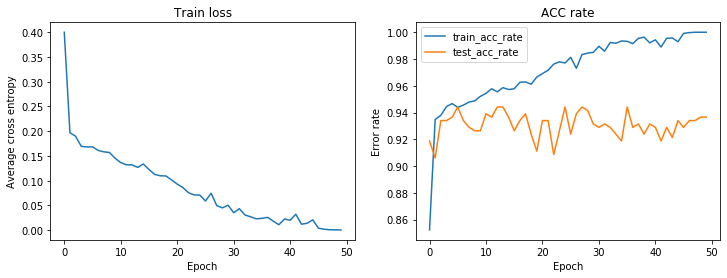

In [8]:
fig=plt.figure(figsize=(12,4))
##
plt.subplot(121) 
plt.plot(range(n_epoch), cross_entropy)
plt.xlabel("Epoch")
plt.ylabel("Average cross entropy")
plt.title('Train loss')
##
plt.subplot(122) 
plt.plot(range(n_epoch), train_acc_rate, label='train_acc_rate')
plt.plot(range(n_epoch), test_acc_rate, label='test_acc_rate')
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.title('ACC rate')
plt.legend(loc='best')

plt.show()

## 2.3

In [9]:
cnn_model.eval()
test_data = Variable(test_data)
test_labels = Variable(test_labels)
test_output = cnn_model(test_data.float())
# convert output probabilities to predicted class
_, test_pred = torch.max(test_output.data, 1)
##
train_data = Variable(train_data)
train_labels = Variable(train_labels)
train_output = cnn_model(train_data.float())
# convert output probabilities to predicted class
_, train_pred = torch.max(train_output.data, 1)

In [10]:
test_confusion = confusion_matrix(test_labels, test_pred)
test_ACC = np.diag(test_confusion)/np.sum(test_confusion, axis=1)
train_confusion = confusion_matrix(train_labels, train_pred)
train_ACC = np.diag(train_confusion)/np.sum(train_confusion, axis=1)

In [11]:
ACC_table = pd.DataFrame({'class':['bad', 'good', 'None'], 'Train': train_ACC, 'Test': test_ACC})
ACC_table

,class,Train,Test
0,bad,1.0,0.921348
1,good,1.0,0.978799
2,None,1.0,0.454545


In [6]:
test_csv = pd.read_csv('problem2-CNN/test.csv')
test_name = pd.unique(test_csv['filename'])

In [7]:
def image_add_labels(test_csv, test_name, test_num, test_pred, pic):
    filepath = 'problem2-CNN/images/'
    filename = test_name[pic]
    print(filename)
    im = cv2.imread(filepath+filename)
    cumsum_test = np.append(0, np.cumsum(test_num))
    for i in np.arange(cumsum_test[pic], cumsum_test[pic+1]):
        xmin = test_csv['xmin'][i]
        xmax = test_csv['xmax'][i]
        ymin = test_csv['ymin'][i]
        ymax = test_csv['ymax'][i]
        k = int(test_pred[i])
        if k==0:
            color=(255,0,0)
            name='bad'
        elif k==1:
            color=(0,255,0)
            name='good'
        else:
            color=(0,0,255)
            name='none'
        cv2.rectangle(im,(int(xmin),int(ymin)),(int(xmax),int(ymax)),color,3)
        if (ymin > 10):
            cv2.putText(im, name, (int(xmin),int(ymin-6)), cv2.FONT_HERSHEY_TRIPLEX,(xmax-xmin)/63, color, 2)
        else:
            cv2.putText(im, name, (int(xmin),int(ymin+15)), cv2.FONT_HERSHEY_TRIPLEX,(xmax-xmin)/63, color, 2)
    return im

observerbd.com_1580560442.jpg


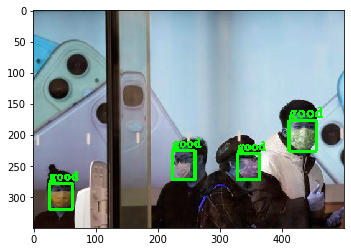

In [11]:
im4 = image_add_labels(test_csv, test_name, test_num, test_pred, 4)
plt.imshow(im4[0:350, 0:500])

0602623232127-web-tete.jpg


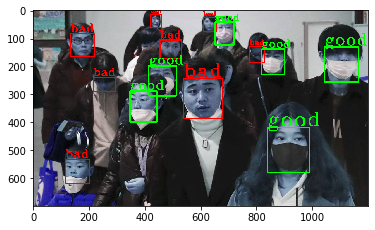

In [12]:
im0 = image_add_labels(test_csv, test_name, test_num, test_pred, 0)
plt.imshow(im0[0:700, 0:1200])

In [8]:
cnn_model2 = CNN_model(num_classes=3)
n_epoch = 50
batch_size = 32
learning_rate = 0.001
# define optimizer and loss_fn
optimizer = Adam(cnn_model2.parameters(), lr=learning_rate, weight_decay=0.0001)
test_labelnum = list(Counter(test_csv['label']).values()) 
weight = torch.tensor([i/sum(test_labelnum) for i in test_labelnum])
loss_fn = nn.CrossEntropyLoss(weight = weight)
##
cross_entropy, train_acc_rate, test_acc_rate\
= run_CNN(n_epoch, batch_size, train_data, train_labels, test_data, test_labels, cnn_model2)

Epoch = 0, train_loss = 0.224385, train_acc = 0.829365, test_acc= 0.890863
Epoch = 1, train_loss = 0.089058, train_acc = 0.924603, test_acc= 0.908629
Epoch = 2, train_loss = 0.082000, train_acc = 0.930839, test_acc= 0.898477
Epoch = 3, train_loss = 0.078675, train_acc = 0.928855, test_acc= 0.926396
Epoch = 4, train_loss = 0.082527, train_acc = 0.931689, test_acc= 0.883249
Epoch = 5, train_loss = 0.076767, train_acc = 0.937075, test_acc= 0.885787
Epoch = 6, train_loss = 0.072870, train_acc = 0.934524, test_acc= 0.918782
Epoch = 7, train_loss = 0.069801, train_acc = 0.939059, test_acc= 0.926396
Epoch = 8, train_loss = 0.069433, train_acc = 0.937925, test_acc= 0.885787
Epoch = 9, train_loss = 0.071300, train_acc = 0.935658, test_acc= 0.918782
Epoch = 10, train_loss = 0.068887, train_acc = 0.935658, test_acc= 0.908629
Epoch = 11, train_loss = 0.063310, train_acc = 0.943594, test_acc= 0.921320
Epoch = 12, train_loss = 0.060640, train_acc = 0.945295, test_acc= 0.926396
Epoch = 13, train_loss

In [9]:
cnn_model2.eval()
test_data = Variable(test_data)
test_labels = Variable(test_labels)
test_output = cnn_model2(test_data.float())
# convert output probabilities to predicted class
_, test_pred = torch.max(test_output.data, 1)
##
train_data = Variable(train_data)
train_labels = Variable(train_labels)
train_output = cnn_model2(train_data.float())
# convert output probabilities to predicted class
_, train_pred = torch.max(train_output.data, 1)

In [10]:
test_confusion = confusion_matrix(test_labels, test_pred)
test_ACC = np.diag(test_confusion)/np.sum(test_confusion, axis=1)
train_confusion = confusion_matrix(train_labels, train_pred)
train_ACC = np.diag(train_confusion)/np.sum(train_confusion, axis=1)
ACC_table = pd.DataFrame({'class':['bad', 'good', 'None'], 'Train': train_ACC, 'Test': test_ACC})
ACC_table

,class,Train,Test
0,bad,0.979239,0.853933
1,good,1.000000,0.992933
2,None,0.567308,0.227273
